# 9. 비지도 학습

- 군집: 비슷한 샘플을 클러스터로 모음
- 이상치 탐지: 정상 데이터가 어떻게 보이는지 학습
- 밀도 추정: PDF를 추정, 이상치 탐지에 널리 사용. 밀도가 낮은 샘플이 이상치일 가능성이 높음

In [23]:
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 9.1 군집

비슷한 샘플을 구별해 하나의 클러스터cluster 또는 그룹으로 할당하는 작업

- 고객 분류: 추천 시스템
- 데이터 분석
- 차원 축소 기법: 샘플의 `친화성` 측정 가능
- 이상치 탐지: 부정 거래 감지
- 준지도 학습: 레이블된 샘플이 적다면 동일 클러스터에 레이블 전파 가능
- 검색 엔진
- 이미지 분할

### 9.1.1 k-평균

- 각 클러스터의 `중심centroid`을 찾고 가장 가까운 클러스터에 샘플을 할당
- `labels_` 변수에 훈련된 샘플의 레이블을 가지고 있음
- `cluster_centers_` 변수의 센트로이드도 확인 가능

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

In [2]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [3]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [5]:
from sklearn.cluster import KMeans

In [28]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [7]:
y_pred

array([0, 4, 1, ..., 2, 1, 4])

In [8]:
y_pred is kmeans.labels_

True

In [10]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

새로운 샘플에 가장 가까운 센트로이드의 클러스터를 할당할 수 있음

In [11]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

- k-평균은 클러스터의 크기가 많이 다르면 잘 작동하지 않음!!
- 하드 군집: 샘플을 하나의 클러스터에 할당
- 소프트 군집: 클러스터마다 샘플에 점수를 부여, `거리/유사도 점수`가 점수가 될 수 있음

`transform()` 샘플과 각 센트로이드 사이의 거리를 반환  
**매우 효율적인 비선형 차원 축소 기법**이 될 수 있음

In [12]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

### k-평균 알고리즘

레이블이나 센트로이드가 주어지지 않으면 센트로이드를 랜덤하게 선정하여 샘플에 레이블을 할당하여 업데이트하고, 이를 센트로이드에 변화가 없을 때까지 반복함. 또한 이는 제한된 횟수 안에 수렴하는 걸 보장하나 적절한 솔루션으로 수렴하지 못할 수 있음!

### 센트로이드 초기화 방법
- `init` 매개변수에 센트로이드 리스트를 지정하고 n_init를 1로 설정
- `n_init` 랜덤 초기화를 다르게 하여 여러 번 알고리즘을 실행하고 좋은 솔루션 선택.
- `이너셔` 샘플과 센트로이드 사이의 거리 측정, 이너셔가 가장 낮은 모델을 반환하게 됨. `inertia_`로 값 확인 가능

In [13]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

### k 평균 속도 개선과 미니배치 k 평균

- 전체 데이터셋을 사용해 반복하지 않고 각 반복마다 미니배치를 사용해 센트로이드를 조금씩 이동하는 방식
- 알고리즘의 속도가 빠르지만 이너셔가 일반보다 조금 더 나쁨

In [18]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters = 5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

### 최적의 클러스터 개수 찾기

- 가장 작은 이너셔를 가진 모델을 선택하는게 최적의 방법이 아님
- 이너셔 그래프 엘보elbow로 판별할 수도 있으나 엉성
- `실루엣 점수`: 모든 샘플에 대한 실루엣 계수의 평균, `silhouette_score`로 확인 가능

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

그림 저장: inertia_vs_k_plot


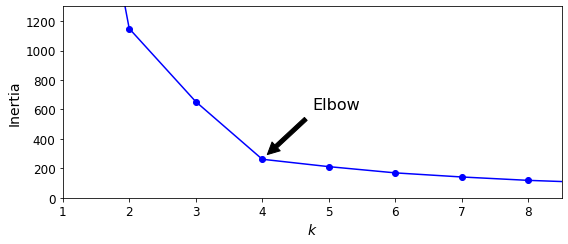

In [24]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

**실루엣 다이어그램**

<img src='https://ichi.pro/assets/images/max/724/1*yVZ48l-E1L_A-tnXV5I8_g.png'>

- 높이: 클러스터가 포함하고 있는 샘플 개수
- 너비: 클러스터에 포함된 샘플의 정렬된 실루엣 계수
- 파선: 각 클러스터 개수에 해당하는 실루엣 점수

### 9.1.2 k 평균의 한계

- 장점: 속도가 빠르고 확장이 용이
- 단점: 최적이 아닌 솔루션을 피하려 알고리즘을 여러 번 실행, 클러스터 개수를 지정해야 함, 클러스터의 크기/밀집도가 다르거나 원형이 아닐 경우 잘 작동하지 않음
- => 데이터에 따라 잘 수행할 수 있는 군집 알고리즘이 다름! (ex 타원 데이터는 가우시안 혼합 모델 사용)
- k 평균을 실행하기 전 입력 특성의 스케일을 맞추는 것이 중요

### 9.1.3 군집을 사용한 이미지 분할

- 이미지를 세그먼트 여러 개로 분할, 동일한 종류의 물체에 속한 픽셀은 같은 세그먼트에 할당
- 여기서는 색상 분할을 사용

In [34]:
from matplotlib.image import imread
image = imread('ladybug.png')
image.shape

(533, 800, 3)

In [35]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

3D 배열로 표현된 이미지; 차원의 크기, 너비, 컬러 채널 개수

In [36]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)

for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### 9.1.4 군집을 사용한 전처리
지도 학습 알고리즘의 전처리 단계로 군집 사용 가능

In [37]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [39]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [40]:
log_reg.score(X_test, y_test)

0.9688888888888889

k 평균을 전처리로 사용해 좋아지는지 확인, 우선 50개의 클러스터로 훈련 세트를 모아 거리로 바꾸고 회귀 모델 적용

In [41]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.98

오차율이 줄었다! 차원은 감소했지만 변환된 데이터셋이 원본보다 잘 구분할 수 있기 때문.

그리드서치를 사용해 최적의 클러스터 개수 찾기

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.3s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.3s
[CV] 

[CV] ............................ kmeans__n_clusters=21, total=   3.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   5.0s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   5.0s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   4.9s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   6.1s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   5.3s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   4.7s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   5.1s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   5.4s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   5.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   5.9s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   5.3s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   5.3s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   5.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   7.8s
[CV] kmeans__n_clusters=60 ...........................................
[CV] ............................ kmeans__n_clusters=60, total=   8.1s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   6.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   7.1s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   5.0s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   5.0s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   4.8s
[CV] kmeans__n_clusters=62 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] ............................ kmeans__n_clusters=69, total=   5.0s
[CV] kmeans__n_clusters=70 ...........................................
[CV] ............................ kmeans__n_clusters=70, total=   4.4s
[CV] kmeans__n_clusters=70 ...........................................
[CV] ............................ kmeans__n_clusters=70, total=   4.4s
[CV] kmeans__n_clusters=70 ...........................................
[CV] ............................ kmeans__n_clusters=70, total=   4.6s
[CV] kmeans__n_clusters=71 ...........................................
[CV] ............................ kmeans__n_clusters=71, total=   4.4s
[CV] kmeans__n_clusters=71 ...........................................
[CV] ............................ kmeans__n_clusters=71, total=   4.6s
[CV] kmeans__n_clusters=71 ...........................................
[CV] ............................ kmeans__n_clusters=71, total=   4.7s
[CV] kmeans__n_clusters=72 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=89, total=   3.9s
[CV] kmeans__n_clusters=89 ...........................................
[CV] ............................ kmeans__n_clusters=89, total=   4.2s
[CV] kmeans__n_clusters=89 ...........................................
[CV] ............................ kmeans__n_clusters=89, total=   4.0s
[CV] kmeans__n_clusters=90 ...........................................
[CV] ............................ kmeans__n_clusters=90, total=   4.4s
[CV] kmeans__n_clusters=90 ...........................................
[CV] ............................ kmeans__n_clusters=90, total=   4.5s
[CV] kmeans__n_clusters=90 ...........................................
[CV] ............................ kmeans__n_clusters=90, total=   4.6s
[CV] kmeans__n_clusters=91 ...........................................
[CV] ............................ kmeans__n_clusters=91, total=   4.0s
[CV] kmeans__n_clusters=91 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 21.1min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [43]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [44]:
grid_clf.score(X_test, y_test)

0.98

### 9.1.5 군집을 사용한 준지도 학습

레이블이 없는 데이터가 있는 데이터보다 많을 때, 같은 클러스터의 레이블을 전파하는 방법

In [45]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(multi_class='ovr', random_state=42)

In [46]:
log_reg.score(X_test, y_test)

0.8333333333333334

개선 필요. 센트로이드에 가장 가까운 이미지, `대표 이미지` 찾기

In [47]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

수동으로 레이블 할당

In [48]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

In [49]:
log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9266666666666666

레이블을 동일한 클러스터에 있는 모든 샘플로 전파.

In [50]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [51]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9111111111111111

센트로이드와 가까운 샘플 20%에만 레이블 전파

In [52]:
percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [53]:
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

C:\Users\tende\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9266666666666666

In [54]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896193771626297

### 능동 학습
- 모델과 훈련 세트를 지속적으로 향상시키기 위함
- 불확실성 샘플링이 널리 사용됨: 레이블된 샘플에서 모델을 훈련해 레이블되지 않은 샘플에 대한 예측을 만들고, 불확실하게 예측한 샘플을 전문가에게 보내 레이블 붙이기

### 9.1.6 DBSCAN

- 밀집된 연속적 지역을 클러스터로 정의
- 핵심 샘플, 이웃이 아닌 샘플은 이상치로 판단
- 모든 클러스터가 충분히 밀집되어있어 그렇지 않은 지역과 잘 구분될 때 좋은 성능을 냄

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [56]:
dbscan.labels_

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

- 인덱스가 -1인 샘플은 이상치로 판단했다는 뜻. 
- `core_sample_indices_`에서 핵심 샘플 인덱스 확인 가능
- 핵심 샘플 자체는 `components_`에서 확인 가능

In [57]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [58]:
dbscan.components_[:10]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

DBSCAN은 fit_predict()를 제공. 이 알고리즘은 새로운 샘플에 대해 클러스터를 예측할 수 없다는 뜻!  
따라서 사용자가 필요한 예측기를 선택해야 함

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [60]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([6, 0, 3, 2], dtype=int64)

In [61]:
knn.predict_proba(X_new)

array([[0.24, 0.  , 0.  , 0.  , 0.  , 0.  , 0.76],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.3 , 0.7 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]])

In [62]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  3, -1], dtype=int64)

- 클러스터의 모양과 개수에 상관없이 감지할 수 있음
- 이상치에 안정적이고 하이퍼파라미터가 eps, min_samples의 두 개
- 다만 밀집도가 크게 다르면 모든 클러스터를 올바르게 잡아내는 것이 불가능

### 9.1.7 다른 군집 알고리즘

- 병합 군집: 클러스터 계층을 밑바닥부터 위로 쌓아 구성
- BIRCH: 대규모 데이터셋을 위해 고안
- 평균-이동: 샘플을 중심으로 하는 원을 그리고, 원의 중심을 평균점으로 이동해 지역의 최대 밀도를 찾을 때까지 반복
- 유사도 전파: 투표 방식을 사용하여 자신을 대표할 수 있는 비슷한 샘플에 투표
- 스펙트럼 군집: 샘플 사이의 유사도 행렬을 받아 저차원 임베딩

## 9.2 가우시안 혼합

- 밀집도 추정, 군집, 이상치 탐지에 사용 가능
- 샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률 모델. 일반적으로 타원형

In [63]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [65]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [66]:
gm.weights_

array([0.39054348, 0.40008962, 0.2093669 ])

In [67]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [-1.40754214,  1.42716873],
       [ 3.40196611,  1.05838748]])

In [68]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]]])

In [69]:
gm.converged_

True

In [70]:
gm.n_iter_

4

In [71]:
gm.predict(X)
gm.predict_proba(X)

array([[9.77227791e-01, 6.79898914e-07, 2.27715290e-02],
       [9.83288385e-01, 6.77104389e-04, 1.60345103e-02],
       [7.51824662e-05, 9.99922915e-01, 1.90251273e-06],
       ...,
       [4.35053542e-07, 2.17938894e-26, 9.99999565e-01],
       [5.27837047e-16, 1.50679490e-41, 1.00000000e+00],
       [2.32355608e-15, 8.21915701e-41, 1.00000000e+00]])

가우시안 혼합 모델은 생성 모델이라 새로운 샘플을 만들 수 있고 주어진 위치에서 모델의 밀도를 추정할 수 있음

In [72]:
X_new, y_new = gm.sample(6)
X_new

array([[-1.36682137, -1.31519974],
       [-0.64497942,  0.11734756],
       [-1.79561581,  1.11145103],
       [-1.71806799,  1.72931165],
       [-2.04402457,  0.14064746],
       [ 4.7660653 ,  0.63849293]])

In [73]:
y_new

array([0, 0, 1, 1, 1, 2])

In [74]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

### 9.2.1 가우시안 혼합을 사용한 이상치 탐지

- 보통과 많이 다른 샘플을 감지하는 작업
- 밀도가 낮은 지역에 있는 샘플을 이상치로 볼 수 있음

In [75]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

`특이치 탐지`: 이상치로 오염되지 않은 깨끗한 데이터셋에서 훈련하는 점이 이상치와 다름.  
이상치 탐지는 데이터셋 정제에 자주 사용됨.

### 9.2.2 클러스터 개수 선택

- BIC나 AIC와 같은 이론적 정보 기준을 최소화하는 모델을 찾음
- 모두 학습할 파라미터가 많은 모델에게 디메릿을 주고 데이터에 잘 학습하는 모델에게 메리트를 줌

In [76]:
gm.bic(X)

8189.662685850679

In [77]:
gm.aic(X)

8102.437405735641

### 9.2.3 베이즈 가우시안 혼합 모델

- 불필요한 클러스터의 가중치를 0으로 만드는 클래스
- 최적의 클러스터 개수보다 큰 컴포넌트의 개수를 지정

In [78]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)
np.round(bgm.weights_, 2)

array([0.4 , 0.2 , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### 9.2.4 이상치 탐지와 특이치 탐지를 위한 다른 알고리즘

- PCA
- Fast-MCD
- 아이솔레이션 포레스트
- LOF
- one-class SVM